In [307]:
import pickle as pkl
import numpy as np
import pandas as pd
import requests as rq
import json
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.cm as cm
from empath import Empath
import math

In [73]:
RedditData = "../Data/reddit_suicideWatch/suicidewatch.pickl"

In [3]:
data = pd.read_pickle(open(RedditData,'rb'))

In [4]:
data.head()

,approved_by,archived,author,author_flair_css_class,author_flair_text,banned_by,body,body_html,controversiality,created,...,pronouns,pronounsNo,sentencesNo,definiteArticlesNo,firstPersonPronouns,firstPersonPronounsNo,LL,afinn,labmt,firstPersonPronounsRatio
0,NaN,True,freakball,None,None,NaN,"Thats it, I'm starting the church of mr rogers.",NaN,0.0,NaN,...,"{u'I': 1, u'it': 1}",2.0,1,1.0,{u'I': 1},1.0,-10.621782,0.000000,0.124441,0.500000
1,NaN,True,[deleted],None,None,NaN,[deleted],NaN,0.0,NaN,...,{},0.0,1,0.0,{},0.0,NaN,NaN,NaN,NaN
2,NaN,True,[deleted],None,None,NaN,[deleted],NaN,0.0,NaN,...,{},0.0,1,0.0,{},0.0,NaN,NaN,NaN,NaN
3,NaN,True,[deleted],None,None,NaN,A really gorgeous album that came out in 2007 ...,NaN,0.0,NaN,...,"{u'I': 5, u'you': 4, u'It': 3, u'yourself/your...",18.0,11,6.0,{u'I': 5},5.0,-10.323336,1.639824,0.854738,0.277778
4,NaN,True,sub_o,None,None,NaN,"what you wish, is their happiness. you don't w...",NaN,0.0,NaN,...,"{u'we': 4, u'your': 2, u'them': 8, u'it': 3, u...",49.0,26,7.0,"{u'our': 1, u'we': 4}",5.0,-9.130422,2.092457,2.318952,0.102041


In [817]:
filteredData = data[((data['author'] != '[deleted]') & (pd.notnull(data['permalink']))  & (data['num_comments'] > 0 ) ) ]

In [818]:
len(filteredData)

50754

In [819]:
# pd.to_pickle(filteredData , "../Data/reddit_suicideWatch/filteredSuicideWatch_All_valid.pkl")

In [7]:
filteredData.iloc[12]['id']

u'dgfma'

In [352]:
# thread[0]

In [353]:
def sanitizeText(text):
    return text.encode('utf8').replace('\n', '').replace('\r', '')
    
def getAffects(text):
    lexicon = Empath()
    affects = lexicon.analyze(text , normalize=False)
    return affects


In [379]:

def getSubThread(url):
    session_headers = {
    'Host': 'www.reddit.com',
    'Connection': 'keep-alive',
    'Cache-Control': 'max-age=0',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    #'Referer': 'http://localhost:9000/notebooks/Reddit/Notebooks/SuicideWatchSubreddit.ipynb'
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-GB,en-US;q=0.8,en;q=0.6',
    'Cookie': "loid=00000000000gslzvdi.2.1507591930964.Z0FBQUFBQlozQWI3M243MTdFMUgzNWtQNzNVbzg5Z3NXYmxpLUdRTWVXdEpWQzBfbkxBSVNNVVF3dE1zQlN5cVMzeGtxZXlmT0JQY2JvTld2NWlVeGlGeFpkNnBYM2ZIYlNNR2xMWGFFS3hieDZpWEJ5OVlyTng0MUFZZjNYdjQ0ZURFNTFlSmlVRGw; edgebucket=T8nkTF0z7WPnNzlE8B; __gads=ID=ab9c1b0fcb7eaefc:T=1507591936:S=ALNI_Mao2tvEoyJzEDEuxxhfZBlOQHXlsA; eu_cookie_v2=3; _ga=GA1.2.1088810883.1507591931; __utma=55650728.1088810883.1507591931.1507912304.1507912553.14; __utmz=55650728.1507912553.14.11.utmcsr=reddit|utmccn=(not%20set)|utmcmd=hot|utmcct=comments; aa=1; _recentclicks2=t3_7cfzsx%2Ct3_7cfw08%2Ct3_7cdofu%2Ct3_7caog1%2Ct3_7cdvud; _recent_srs=t5_2qpzs%2Ct5_2qh1q%2Ct5_2qh49%2Ct5_2rtff%2Ct5_36buk%2Ct5_2r7yd%2Ct5_2rks3%2Ct5_3j2jr%2Ct5_2sumw%2Ct5_2xp2o; pc=r3; session_tracker=tPgx9U9yPt99jYRDqC.0.1510585492994.Z0FBQUFBQmFDYlNWcWZHclI5WWxDWW9kQ0dURk9FRU9BZjFJTURWZElzaldRbkROaEJUOWE1czRQUWxPUzUwOFFwY3R3ckI5VkNDUlhJc01NVEtEeHVWd25CdUpXWEI1X012RkJaS3cyNXdNbk5vOE9DSXp5ZlhuTzF3a2pxT2dLZ3laMDhtQlhib3k; initref=localhost"
    }

    client = rq.session()
    resp = client.get(url , headers=session_headers)
    if resp.status_code == 200:
        json_data = json.loads(resp.text)
        return json_data

    else:
        print "Failed to get the thread"
        return None

In [380]:
def getScaledSizes(graph):
    affects = nx.get_node_attributes(graph, 'ups')
    sizes = [int(affects[v]) for v in graph.nodes()]
    normedSizes = [i + 10 for i in sizes]
    scaledSizes = [v*(2^(v-np.min(normedSizes)))+100 for v in normedSizes]
    return scaledSizes

In [745]:
# def parseChildren(jsonDict , graph):
#     if jsonDict['kind'] == 'more':
#         print "Needs deeper probing !!"
#         return
#     data = jsonDict['data']
#     affects = getAffects(sanitizeText(data['body']))
# #     print data['name']
#     propertyDict = {'author' : data['author'] , 'ups' : data['ups'] , 'downs' : data['downs'] , 'text' : sanitizeText(data['body']) , 'depth' : data['depth'] , 'affects' : sum(affects.values()) }
#     graph.add_node(data['name'] , propertyDict )
#     graph.add_edge(data['name'], data['parent_id'] , weight=1 )
#     if data['replies'] != '':
#         if len(data['replies']['data']['children']) > 0:
#             for k in data['replies']['data']['children']:
#                 parseChildren(k, graph)
#     else:
#         return
    
def parseChildren(jsonDict , graph , permUrl , motherDepthOffset):
    if jsonDict['kind'] == 'more':
        print "Need Deeper Probing !!!!!! "
        deepterThreadId = jsonDict['data']['parent_id'].split('_')[1]
        offsetDepth = motherDepthOffset + jsonDict['data']['depth']+1
        print deepterThreadId
        getUrl = permUrl+deepterThreadId+"/.json"
        print "Getting Nested Thread from : " + getUrl
        deeperDict = getSubThread(getUrl)
        if deeperDict != None:
            graph = parseRedditJsonConvTree(deeperDict,graph,offsetDepth)
            return
        else:
            print "Silently Returning"
            return
        
    data = jsonDict['data']
    affects = getAffects(sanitizeText(data['body']))
    # print data['name']
    propertyDict = {'author' : data['author'] , 'ups' : data['ups'] , 'downs' : data['downs'] , 'text' : sanitizeText(data['body']) , 'depth' : (motherDepthOffset + data['depth'])-1 , 'affects' : sum(affects.values()) }
    graph.add_node(data['name'] , propertyDict )
    graph.add_edge(data['name'], data['parent_id'] , weight=1 )
    if data['replies'] != '':
        if len(data['replies']['data']['children']) > 0:
            for k in data['replies']['data']['children']:
                parseChildren(k, graph , permUrl , motherDepthOffset )
    else:
        return
    
def parseRedditJsonConvTree(jsonDict,motherGraph=None,DepthOffset=0):
    if motherGraph != None:
        replyGraph = motherGraph
        root = jsonDict[1]
        perma = root['data']['children'][0]['data']['permalink']
        url = "http://www.reddit.com"+perma

    else:
        root = jsonDict[0]
        perma = root['data']['children'][0]['data']['permalink']
        url = "http://www.reddit.com"+perma
        replyGraph = nx.DiGraph()
        data = root['data']['children'][0]['data']
        affects = getAffects(data['selftext'])
        propertyDict = {'author' : data['author'] , 'ups' : data['ups'] , 'downs' : data['downs'] , 'text' : sanitizeText(data['selftext']) , 'depth' : DepthOffset-1, 'affects' : sum(affects.values())}
        replyGraph.add_node(data['name'] , propertyDict )
    
    if len(jsonDict[1]['data']['children']) > 0:
        for k in jsonDict[1]['data']['children']:
            parseChildren(k , replyGraph , url , DepthOffset)
    return replyGraph
    
    

In [746]:
testperma = filteredData.iloc[2909]['permalink']

url = "http://www.reddit.com"+testperma+".json"
print url


session_headers = {
'Host': 'www.reddit.com',
'Connection': 'keep-alive',
'Cache-Control': 'max-age=0',
'Upgrade-Insecure-Requests': '1',
'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
#'Referer': 'http://localhost:9000/notebooks/Reddit/Notebooks/SuicideWatchSubreddit.ipynb'
'Accept-Encoding': 'gzip, deflate, br',
'Accept-Language': 'en-GB,en-US;q=0.8,en;q=0.6',
'Cookie': "loid=00000000000gslzvdi.2.1507591930964.Z0FBQUFBQlozQWI3M243MTdFMUgzNWtQNzNVbzg5Z3NXYmxpLUdRTWVXdEpWQzBfbkxBSVNNVVF3dE1zQlN5cVMzeGtxZXlmT0JQY2JvTld2NWlVeGlGeFpkNnBYM2ZIYlNNR2xMWGFFS3hieDZpWEJ5OVlyTng0MUFZZjNYdjQ0ZURFNTFlSmlVRGw; edgebucket=T8nkTF0z7WPnNzlE8B; __gads=ID=ab9c1b0fcb7eaefc:T=1507591936:S=ALNI_Mao2tvEoyJzEDEuxxhfZBlOQHXlsA; eu_cookie_v2=3; _ga=GA1.2.1088810883.1507591931; __utma=55650728.1088810883.1507591931.1507912304.1507912553.14; __utmz=55650728.1507912553.14.11.utmcsr=reddit|utmccn=(not%20set)|utmcmd=hot|utmcct=comments; aa=1; _recentclicks2=t3_7cfzsx%2Ct3_7cfw08%2Ct3_7cdofu%2Ct3_7caog1%2Ct3_7cdvud; _recent_srs=t5_2qpzs%2Ct5_2qh1q%2Ct5_2qh49%2Ct5_2rtff%2Ct5_36buk%2Ct5_2r7yd%2Ct5_2rks3%2Ct5_3j2jr%2Ct5_2sumw%2Ct5_2xp2o; pc=r3; session_tracker=tPgx9U9yPt99jYRDqC.0.1510585492994.Z0FBQUFBQmFDYlNWcWZHclI5WWxDWW9kQ0dURk9FRU9BZjFJTURWZElzaldRbkROaEJUOWE1czRQUWxPUzUwOFFwY3R3ckI5VkNDUlhJc01NVEtEeHVWd25CdUpXWEI1X012RkJaS3cyNXdNbk5vOE9DSXp5ZlhuTzF3a2pxT2dLZ3laMDhtQlhib3k; initref=localhost"
}

client = rq.session()

resp = client.get(url , headers=session_headers)

resp.status_code

thread = json.loads(resp.content)

http://www.reddit.com/r/SuicideWatch/comments/r647r/update_i_no_longer_have_anything_to_look_forward/.json


In [823]:
print type(thread[0]['data']['before'])

<type 'NoneType'>


In [747]:

cascadeGraph = parseRedditJsonConvTree(thread )

Need Deeper Probing !!!!!! 
c43hm9m
Getting Nested Thread from : http://www.reddit.com/r/SuicideWatch/comments/r647r/update_i_no_longer_have_anything_to_look_forward/c43hm9m/.json


In [748]:
affects = nx.get_node_attributes(cascadeGraph, 'affects')

In [749]:
print affects

{u't1_c43a5g0': 74.0, u't1_c437ync': 38.0, u't1_c437mtv': 72.0, u't1_c43b716': 24.0, u't1_c43vpa2': 4.0, u't1_c43c3sa': 7.0, u't1_c43b10k': 12.0, u't1_c43ppx5': 0.0, u't1_c43a4in': 120.0, u't1_c43b3fk': 85.0, u't1_c43fat8': 19.0, u't1_c43fosq': 32.0, u't1_c43a4od': 5.0, u't1_c43c1ip': 31.0, u't1_c43jd39': 18.0, u't1_c43b1ty': 5.0, u't1_c43e9nu': 0.0, u't1_c43hm9m': 12.0, u't1_c437fye': 22.0, u't1_c43aypy': 2.0, u't1_c43jt0r': 12.0, u't1_c43ay3u': 10.0, u't1_c43hbea': 34.0, u't1_c43h806': 1.0, u't1_c43fdtn': 1.0, u't1_c43nff9': 6.0, u't1_c43bjsq': 3.0, u't1_c437h8u': 20.0, u't1_c43egzi': 0.0, u't1_c437qso': 66.0, u't1_c43htsk': 9.0, u't1_c439vgo': 55.0, u't1_c43kx0p': 31.0, u't1_c43huwj': 5.0, u't3_r647r': 36.0, u't1_c43fuws': 2.0, u't1_c43ec6f': 1.0, u't1_c43djd2': 26.0, u't1_c439fh9': 7.0, u't1_c439yhh': 26.0, u't1_c43avx5': 4.0, u't1_c437mpc': 15.0, u't1_c45jru9': 1.0, u't1_c43eneq': 10.0, u't1_c45et73': 0.0, u't1_c43cdez': 130.0, u't1_c439emn': 3.0, u't1_c43o7z5': 18.0, u't1_c43j2of

In [750]:
sizes = [int(affects[v]) for v in cascadeGraph.nodes()]

In [751]:
print sizes

[74, 38, 72, 24, 4, 7, 12, 0, 120, 85, 19, 32, 5, 31, 18, 66, 0, 12, 22, 2, 12, 10, 34, 1, 1, 3, 6, 10, 20, 0, 5, 9, 55, 18, 5, 36, 2, 1, 26, 7, 26, 4, 15, 1, 0, 130, 3, 31, 4, 0, 23, 0]


In [752]:
normedSizes = [i + 10 for i in sizes]
scaledSizes = [v*(2^(v-np.min(normedSizes)))+100 for v in normedSizes]
# scaledSizes = normedSizes

In [753]:
print scaledSizes

[6148, 1828, 6168, 984, 184, 185, 408, 120, 15960, 8365, 593, 1528, 205, 1289, 548, 4964, 120, 408, 740, 100, 408, 260, 1508, 133, 133, 113, 164, 260, 760, 120, 205, 309, 3545, 548, 205, 1848, 100, 133, 964, 185, 964, 184, 425, 133, 120, 18020, 113, 1289, 184, 120, 793, 120]


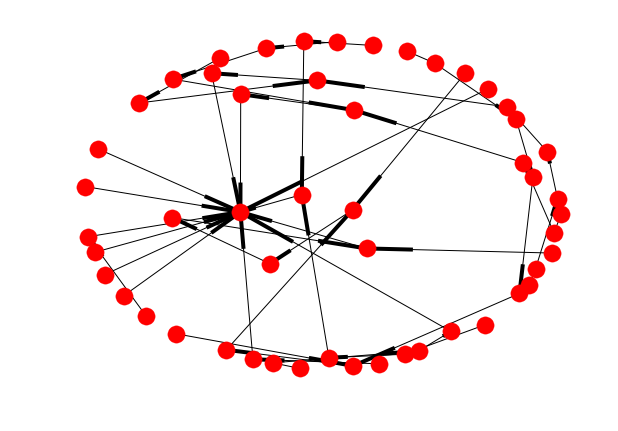

In [754]:
nx.draw(cascadeGraph)

15


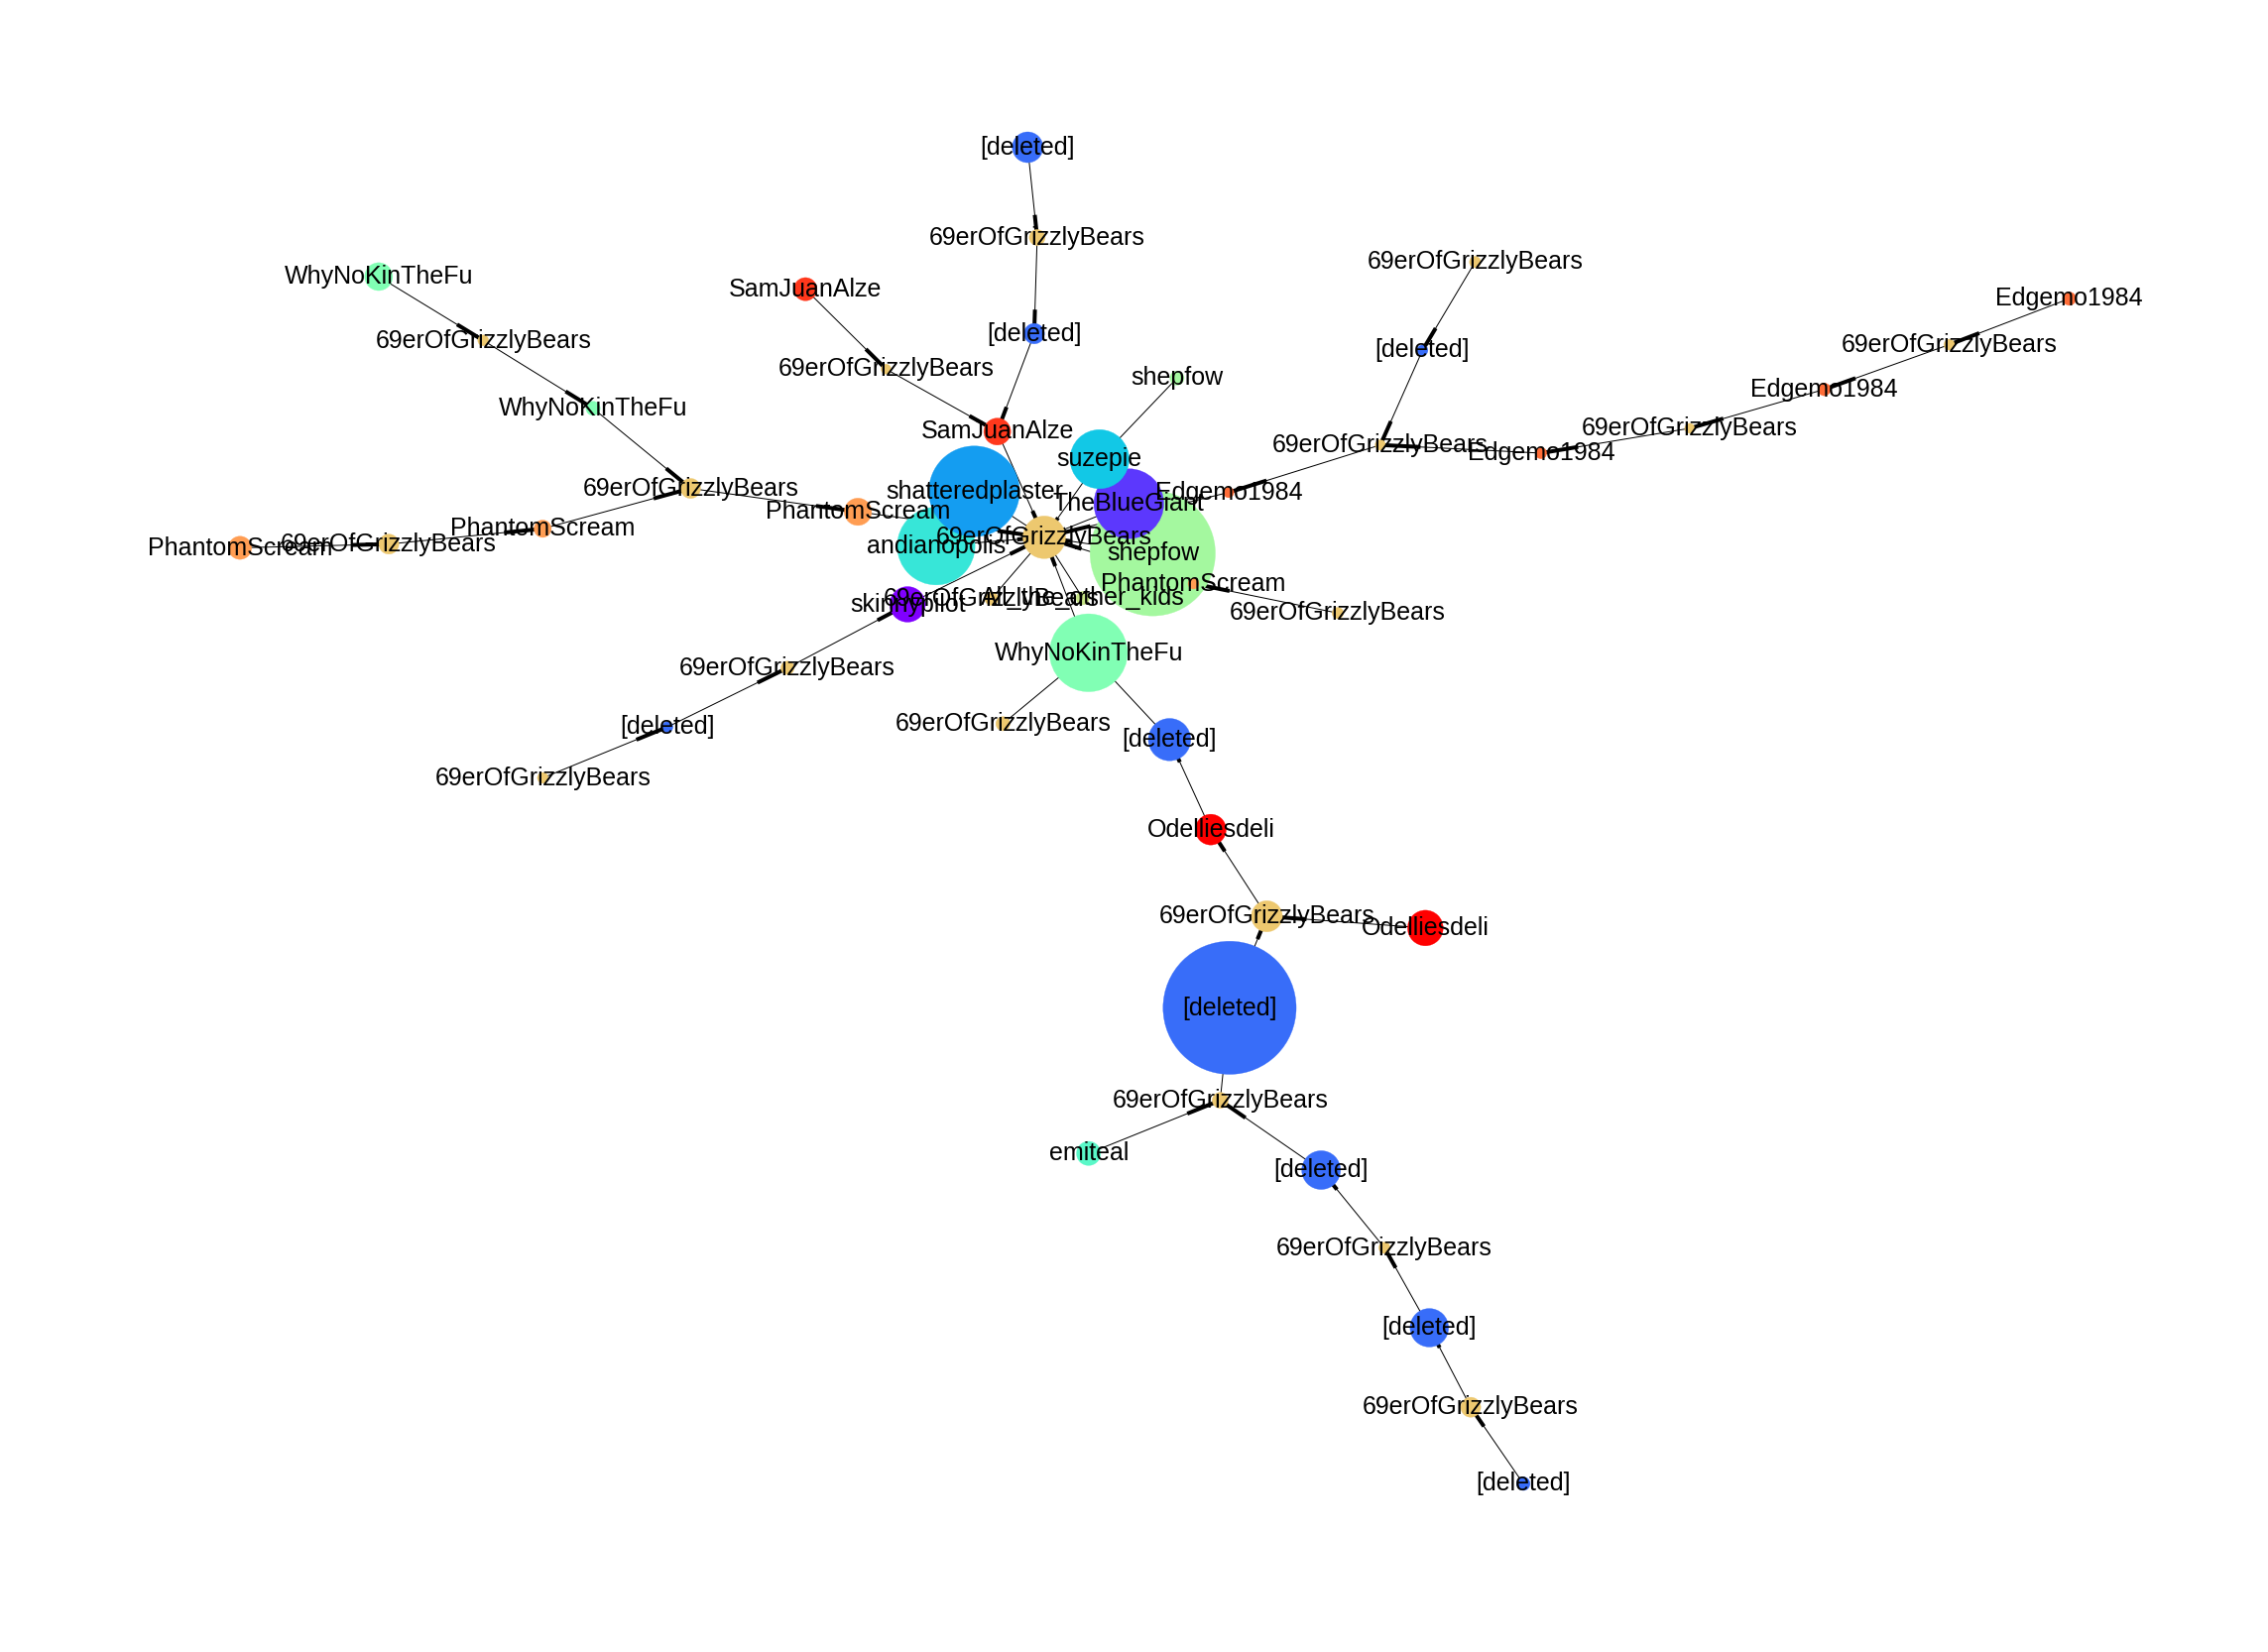

In [755]:

pos = graphviz_layout(cascadeGraph, prog='neato')

usr = list(set(nx.get_node_attributes(cascadeGraph, 'author').values()))
print len(usr)
color=cm.rainbow(np.linspace(0,1,len(usr)))
colorMap = []
lls = {}
for node in cascadeGraph:
    c = usr.index(cascadeGraph.node[node]['author'])
    colorMap.append(color[c])
    lls[node] = cascadeGraph.node[node]['author']
fig, ax = plt.subplots()
fig.set_size_inches(40, 30)
#
nx.draw(cascadeGraph,pos=pos ,node_size=scaledSizes ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
plt.show()

In [71]:
# print nx.get_node_attributes(cascadeGraph,'text')

In [756]:
Allgraphs = "../Data/reddit_suicideWatch/SW_morethan10_graphs_complete_revised/SW_morethan10_replygraphs.pkl"

In [757]:
allGraphs = pkl.load(open(Allgraphs,'rb'))

In [758]:
textDict = {}
for k in allGraphs:
    postText = nx.get_node_attributes(allGraphs[k],'text')
    textDict.update(postText)

In [759]:
len(textDict)

209541

In [760]:
# import csv
# fieldnames = ['postid', 'text']
# with open('../Data/reddit_suicideWatch/SWTextComplete.csv', 'wb') as output_file:
#     dict_writer = csv.DictWriter(output_file, fieldnames=fieldnames)
#     dict_writer.writeheader()
#     for k in textDict:
#         dict_writer.writerow({'postid': k , 'text': textDict[k]})


In [761]:
LIWC = pd.read_csv("/datasets_1/sagarj/IoPPN_collab/reddit_suicideWatch/LIWC2015_SWTextComplete.csv")

In [809]:
len(LIWC)

209541

In [762]:
LIWC.drop(LIWC.index[0])

,A,B,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
1,t1_cgrrngb,I have found cbt very useful. First of all in ...,370,19.18,15.86,93.87,66.68,37.00,18.11,93.24,...,4.59,1.08,0.00,0.00,0.00,0.81,0.00,5.68,0.54,1.62
2,t1_csg5e3g,"True, and things just become harder to deal wi...",29,2.40,4.25,95.26,85.87,14.50,0.00,86.21,...,6.90,0.00,0.00,3.45,0.00,0.00,0.00,3.45,0.00,0.00
3,t1_cte84lp,Maybe you will be next month,6,1.00,99.00,98.01,25.77,6.00,0.00,100.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,t1_c7htg2r,"Please... explain it to me in detail, why me w...",69,15.38,50.00,90.83,1.00,8.62,11.59,95.65,...,5.80,0.00,0.00,2.90,0.00,0.00,0.00,2.90,0.00,0.00
5,t1_c2gfbox,What makes you think you do have any of those?...,22,3.76,99.00,1.00,25.77,22.00,0.00,100.00,...,0.00,0.00,0.00,9.09,0.00,0.00,0.00,0.00,0.00,0.00
6,t1_c261rze,"no, i;d never bother him out of hours and whin...",20,51.43,30.86,43.37,1.00,10.00,0.00,80.00,...,5.00,0.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,t1_c397zq7,You're welcome.,2,1.00,99.00,1.00,99.00,2.00,50.00,100.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.00,0.00,0.00
8,t1_cbimnho,you can talk to me about it,7,5.53,99.00,13.15,25.77,7.00,0.00,100.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,t1_cc7me28,"Before you do anything get to know the world, ...",34,33.48,99.00,66.34,1.00,11.33,5.88,100.00,...,2.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10,t1_ctkv7j8,The problem is that I'm so anti-social that no...,34,2.91,7.08,28.81,1.00,11.33,8.82,97.06,...,0.00,0.00,0.00,0.00,0.00,2.94,0.00,5.88,0.00,0.00


In [763]:
LIWC.head()

,A,B,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,t1_costhd8,It really sounds like you need meds then. Ask ...,46,15.38,99.00,16.76,99.00,9.20,4.35,91.30,...,4.35,0.00,0.0,0.00,0.0,0.00,0.0,4.35,0.00,0.00
1,t1_cgrrngb,I have found cbt very useful. First of all in ...,370,19.18,15.86,93.87,66.68,37.00,18.11,93.24,...,4.59,1.08,0.0,0.00,0.0,0.81,0.0,5.68,0.54,1.62
2,t1_csg5e3g,"True, and things just become harder to deal wi...",29,2.40,4.25,95.26,85.87,14.50,0.00,86.21,...,6.90,0.00,0.0,3.45,0.0,0.00,0.0,3.45,0.00,0.00
3,t1_cte84lp,Maybe you will be next month,6,1.00,99.00,98.01,25.77,6.00,0.00,100.00,...,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00
4,t1_c7htg2r,"Please... explain it to me in detail, why me w...",69,15.38,50.00,90.83,1.00,8.62,11.59,95.65,...,5.80,0.00,0.0,2.90,0.0,0.00,0.0,2.90,0.00,0.00


In [764]:
affectDict = {}
for index , row in LIWC.iterrows():
    affectDict[row['A']] =row['posemo'] - row['negemo'] 
    

In [810]:
len(affectDict)

209541

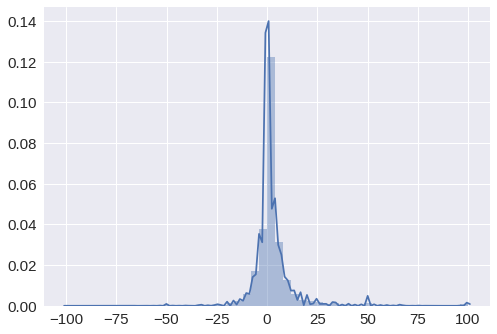

In [765]:
sns.distplot(affectDict.values())

In [766]:
for g in allGraphs:
    
    updateDict = {}
    for n in allGraphs[g].nodes():
        if n not in affectDict:
            continue
        updateDict[n] = affectDict[n]
    nx.set_node_attributes(allGraphs[g] , 'affects' , updateDict)

In [767]:
testGraph = allGraphs[allGraphs.keys()[10]]

In [768]:
nodes =nx.get_node_attributes(testGraph,'author')
edges = testGraph.edges()

2


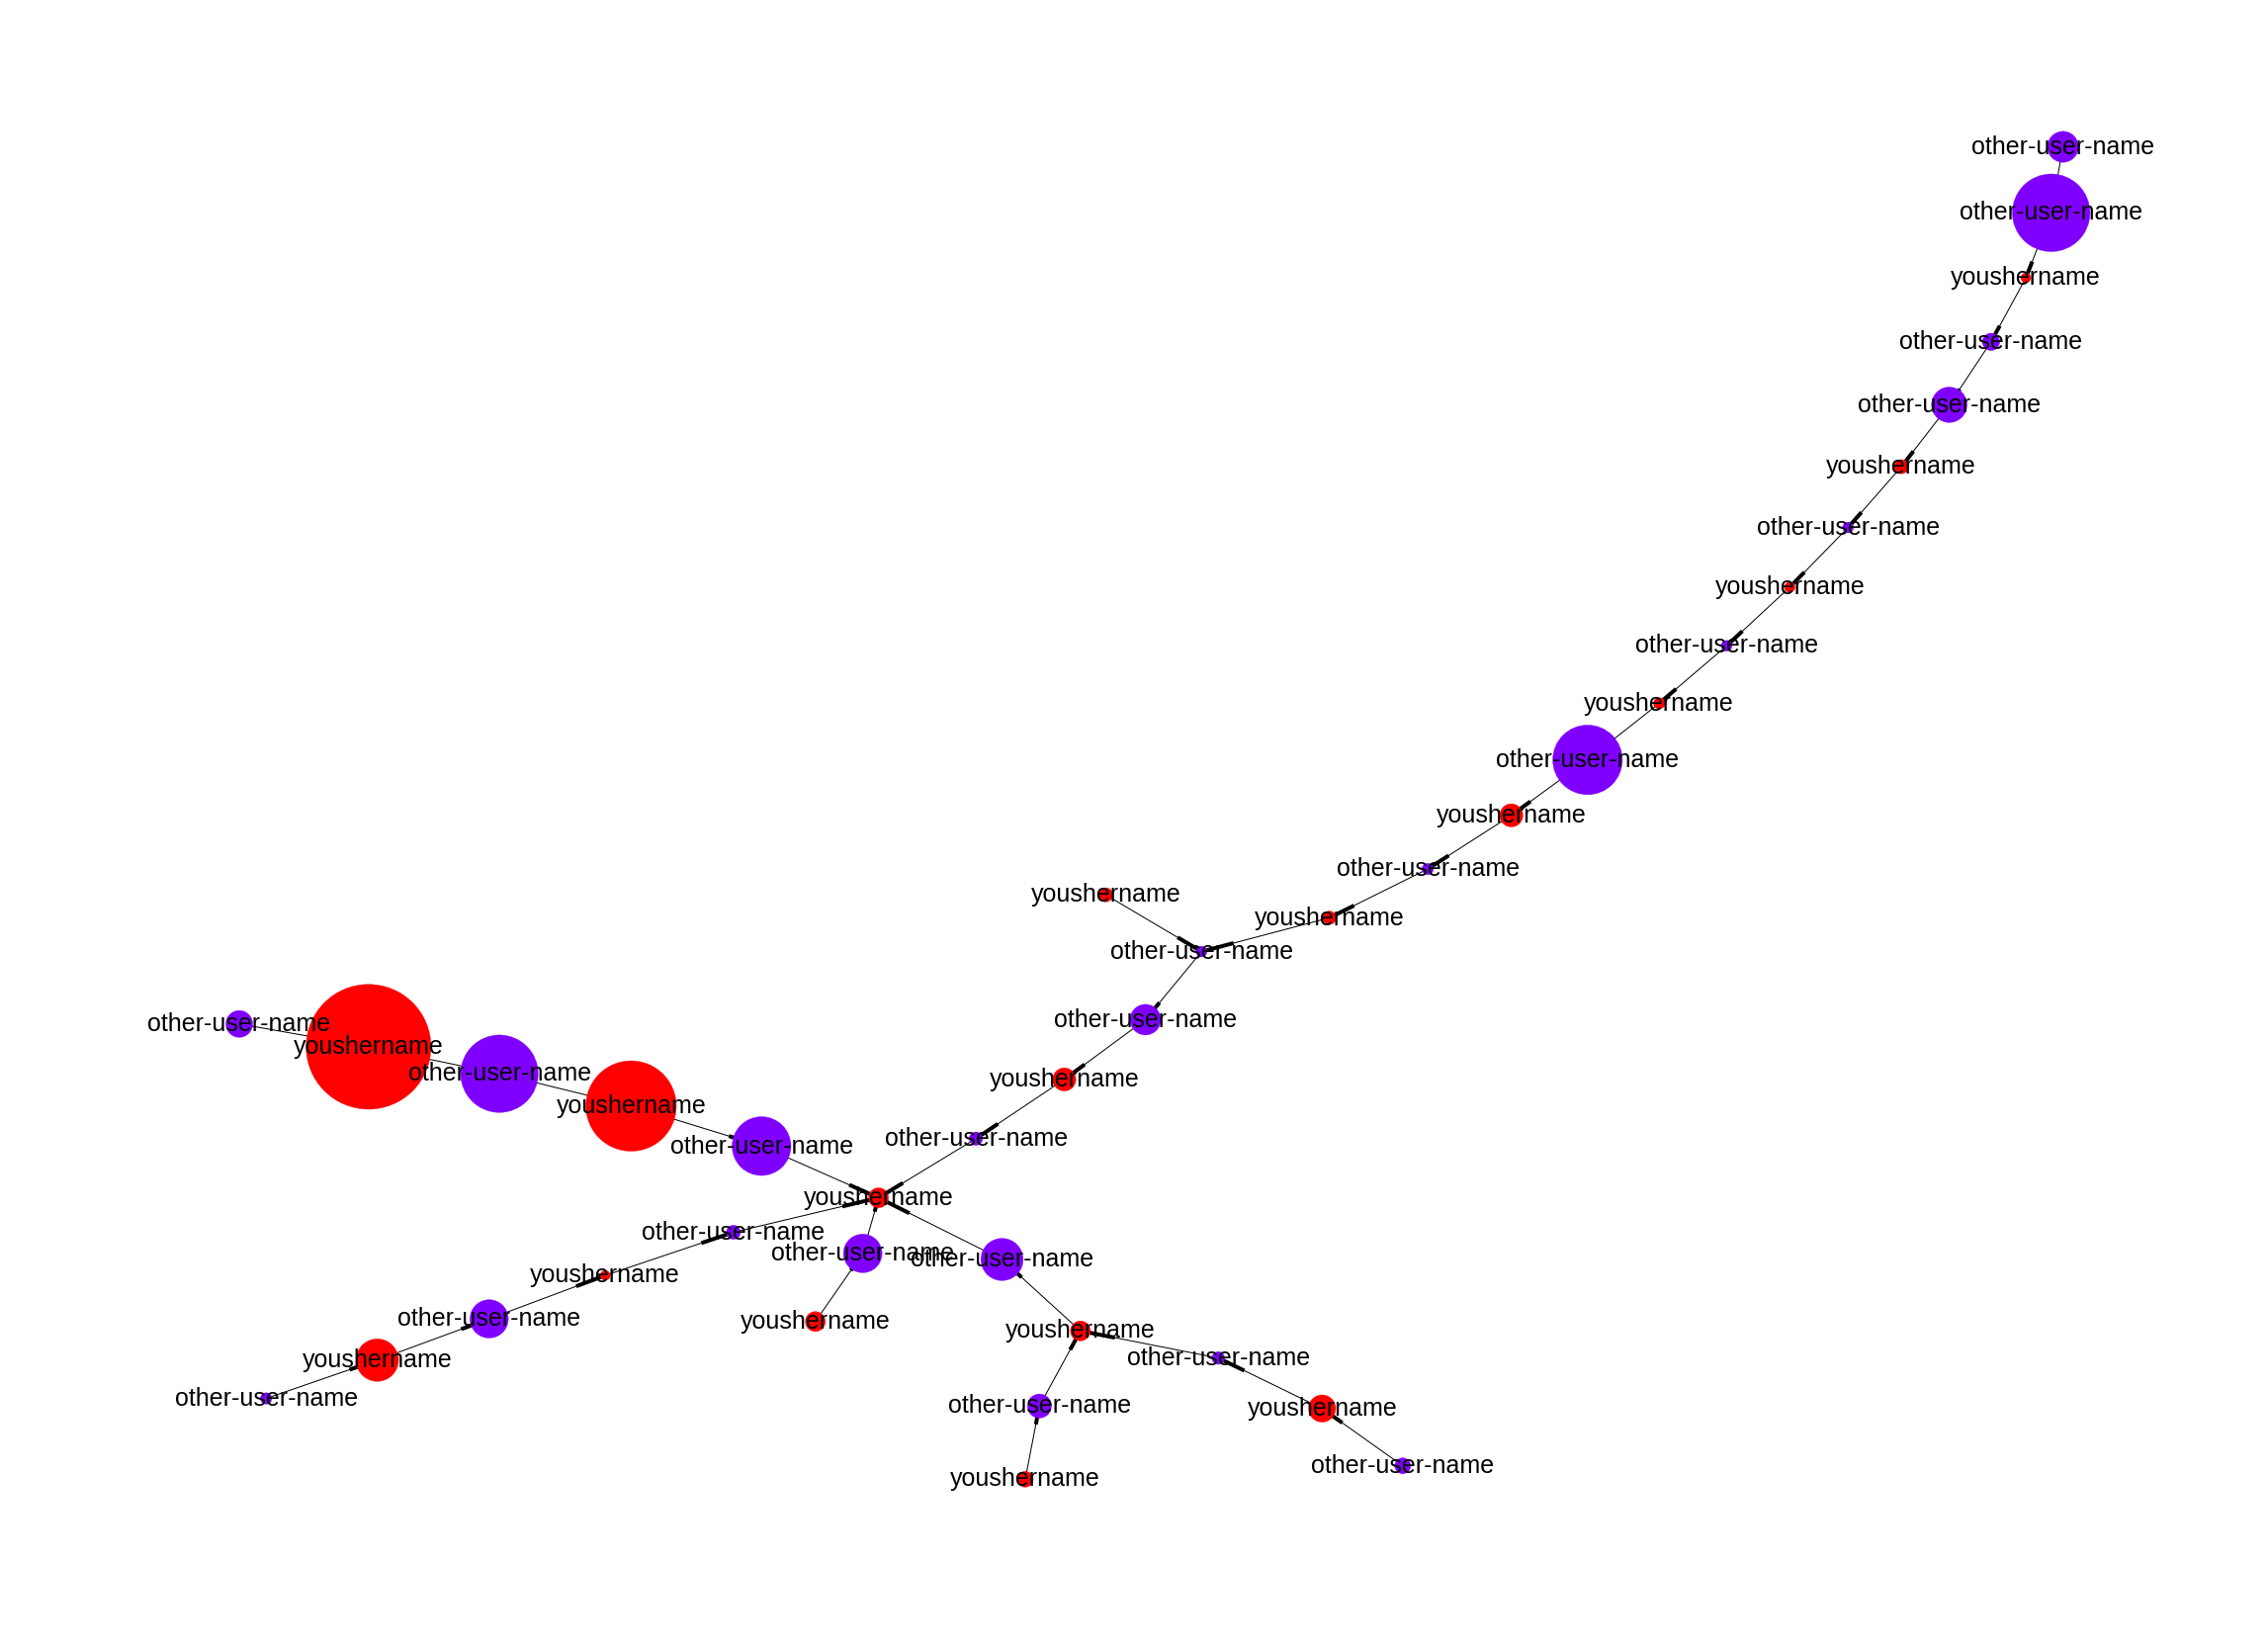

In [808]:
cascadeGraph = allGraphs[allGraphs.keys()[56]]
sizes = getScaledSizes(cascadeGraph)
pos = graphviz_layout(cascadeGraph, prog='neato')

usr = list(set(nx.get_node_attributes(cascadeGraph, 'author').values()))
print len(usr)
color=cm.rainbow(np.linspace(0,1,len(usr)))
colorMap = []
lls = {}
for node in cascadeGraph:
    c = usr.index(cascadeGraph.node[node]['author'])
    colorMap.append(color[c])
    lls[node] = cascadeGraph.node[node]['author']
fig, ax = plt.subplots()
fig.set_size_inches(40, 30)
#
nx.draw(cascadeGraph,pos=pos ,node_size=scaledSizes ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
plt.show()

In [770]:
nx.get_node_attributes(allGraphs[allGraphs.keys()[1150]], 'ups')

{u't1_c4pctc9': 1,
 u't1_c4pctxf': 1,
 u't1_c4pcuz2': 2,
 u't1_c4pd8vc': 2,
 u't1_c4pdmnr': 5,
 u't1_c4pf93p': 1,
 u't1_c4pfbdi': 1,
 u't1_c4pg5vt': 1,
 u't1_c4ph5oy': 1,
 u't1_c4po110': 1,
 u't1_c4po7hl': 2,
 u't1_c4pocq2': 1,
 u't1_c4poiy3': 1,
 u't1_c4poqr4': 1,
 u't1_c4pov1n': 2,
 u't1_c4pp04z': 2,
 u't1_c4pp198': 1,
 u't1_c4pp1mr': 2,
 u't1_c4pp3m8': 1,
 u't1_c4pp5t6': 2,
 u't1_c4pp7gg': 2,
 u't1_c4pp8i7': 1,
 u't1_c4pp8rb': 2,
 u't1_c4pqdaj': 2,
 u't1_c4pqguq': 1,
 u't1_c4prhsg': 2,
 u't1_c4puxer': 1,
 u't3_tsizv': 7}

In [771]:
nx.get_node_attributes(allGraphs[allGraphs.keys()[1150]], 'author').values().count('[deleted]')

2

In [772]:
userDist = [len(list(set(nx.get_node_attributes(allGraphs[g], 'author').values()))) for g in allGraphs]

In [773]:
depthDist = [max(list(set(nx.get_node_attributes(allGraphs[g], 'depth').values()))) for g in allGraphs]

In [774]:
upsDist = [max(list(set(nx.get_node_attributes(allGraphs[g], 'ups').values()))) for g in allGraphs]

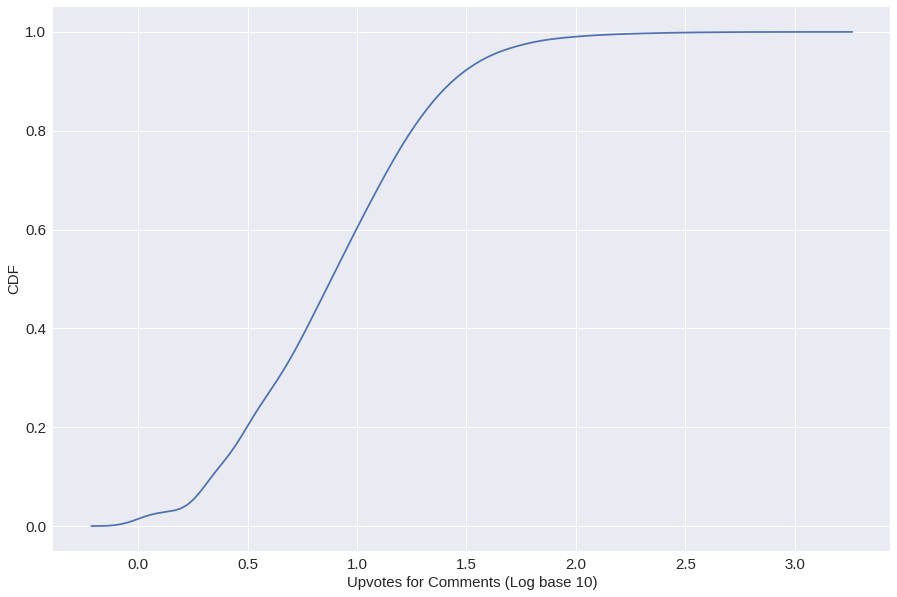

In [775]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(np.log10(upsDist),hist = False,kde_kws=dict(cumulative=True))
sns.set(font_scale=1.5) 
plt.xlabel("Upvotes for Comments (Log base 10)", fontsize = 15)
plt.ylabel("CDF", fontsize = 15)

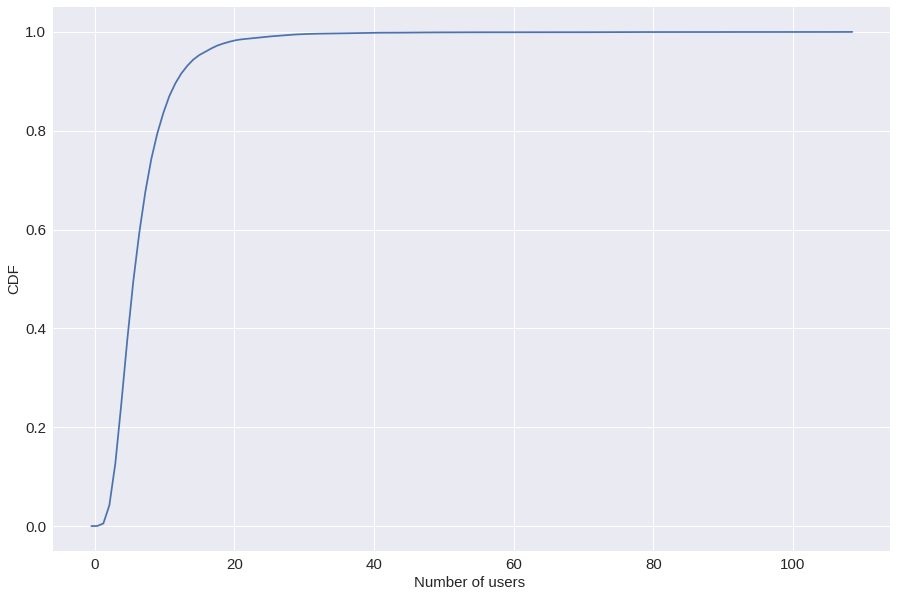

In [776]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(userDist,hist = False,kde_kws=dict(cumulative=True))
sns.set(font_scale=1.5) 
plt.xlabel("Number of users ", fontsize = 15)
plt.ylabel("CDF", fontsize = 15)

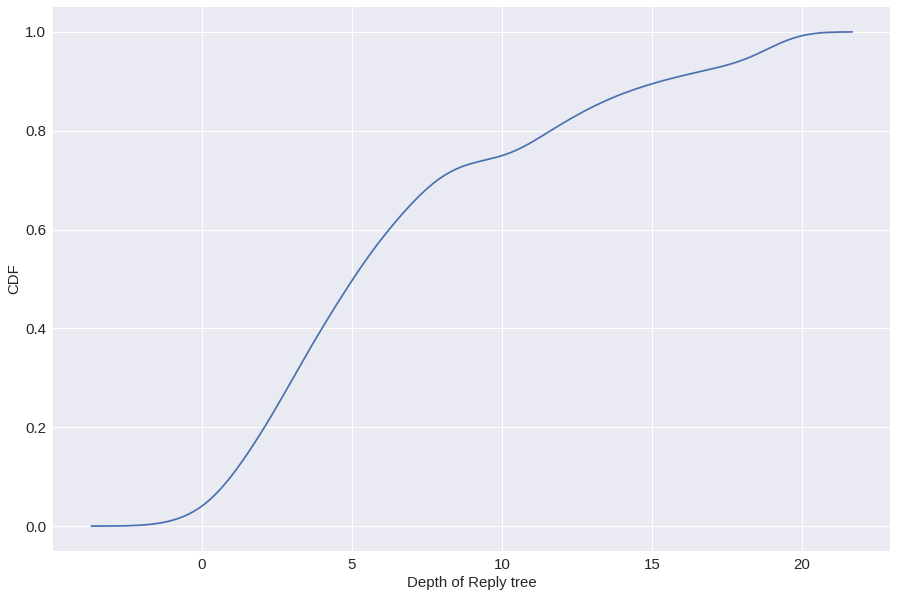

In [777]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(depthDist , hist=False , kde_kws=dict(cumulative=True))
sns.set(font_scale=1.5) 
plt.xlabel("Depth of Reply tree", fontsize = 15)
plt.ylabel("CDF", fontsize = 15)

In [778]:
userGraphs = {}
for i in allGraphs:
    deletedusers = nx.get_node_attributes(allGraphs[i], 'author').values().count('[deleted]')
    if deletedusers > 3:
        continue
    userGraph = nx.DiGraph()
    nodes = nx.get_node_attributes(allGraphs[i],'author')
    for e in allGraphs[i].edges():
        if e[0] not in nodes and e[1] not in nodes:
            continue
        elif e[0] not in nodes:
            src = "deleted"
            dst = nodes[e[1]]
        elif e[1] not in nodes:
            src = nodes[e[0]]
            dst = "deleted"
        else:
            src = nodes[e[0]]
            dst = nodes[e[1]]
        if not userGraph.has_node(src):
            userGraph.add_node(src)
        if not userGraph.has_node(dst):
            userGraph.add_node(dst)  
        if not userGraph.has_edge(src,dst):
            userGraph.add_edge(src, dst , weight=1 )
        else:
            userGraph[src][dst]['weight'] += 1
    userGraphs[i] = userGraph

In [779]:
len(userGraphs)

6403

In [780]:
key = userGraphs.keys()[12]

# cascadeGraph = allGraphs[key]
# sizes = getScaledSizes(cascadeGraph)
# print sizes
# pos = graphviz_layout(cascadeGraph, prog='neato')

# usr = list(set(nx.get_node_attributes(cascadeGraph, 'author').values()))
# print len(usr)
# color=cm.rainbow(np.linspace(0,1,len(usr)))
# colorMap = []
# lls = {}
# for node in cascadeGraph:
#     c = usr.index(cascadeGraph.node[node]['author'])
#     colorMap.append(color[c])
#     lls[node] = cascadeGraph.node[node]['author']
# fig, ax = plt.subplots()
# fig.set_size_inches(40, 30)
# #
# nx.draw(cascadeGraph,pos=pos ,node_size=scaledSizes ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
# plt.show()

9


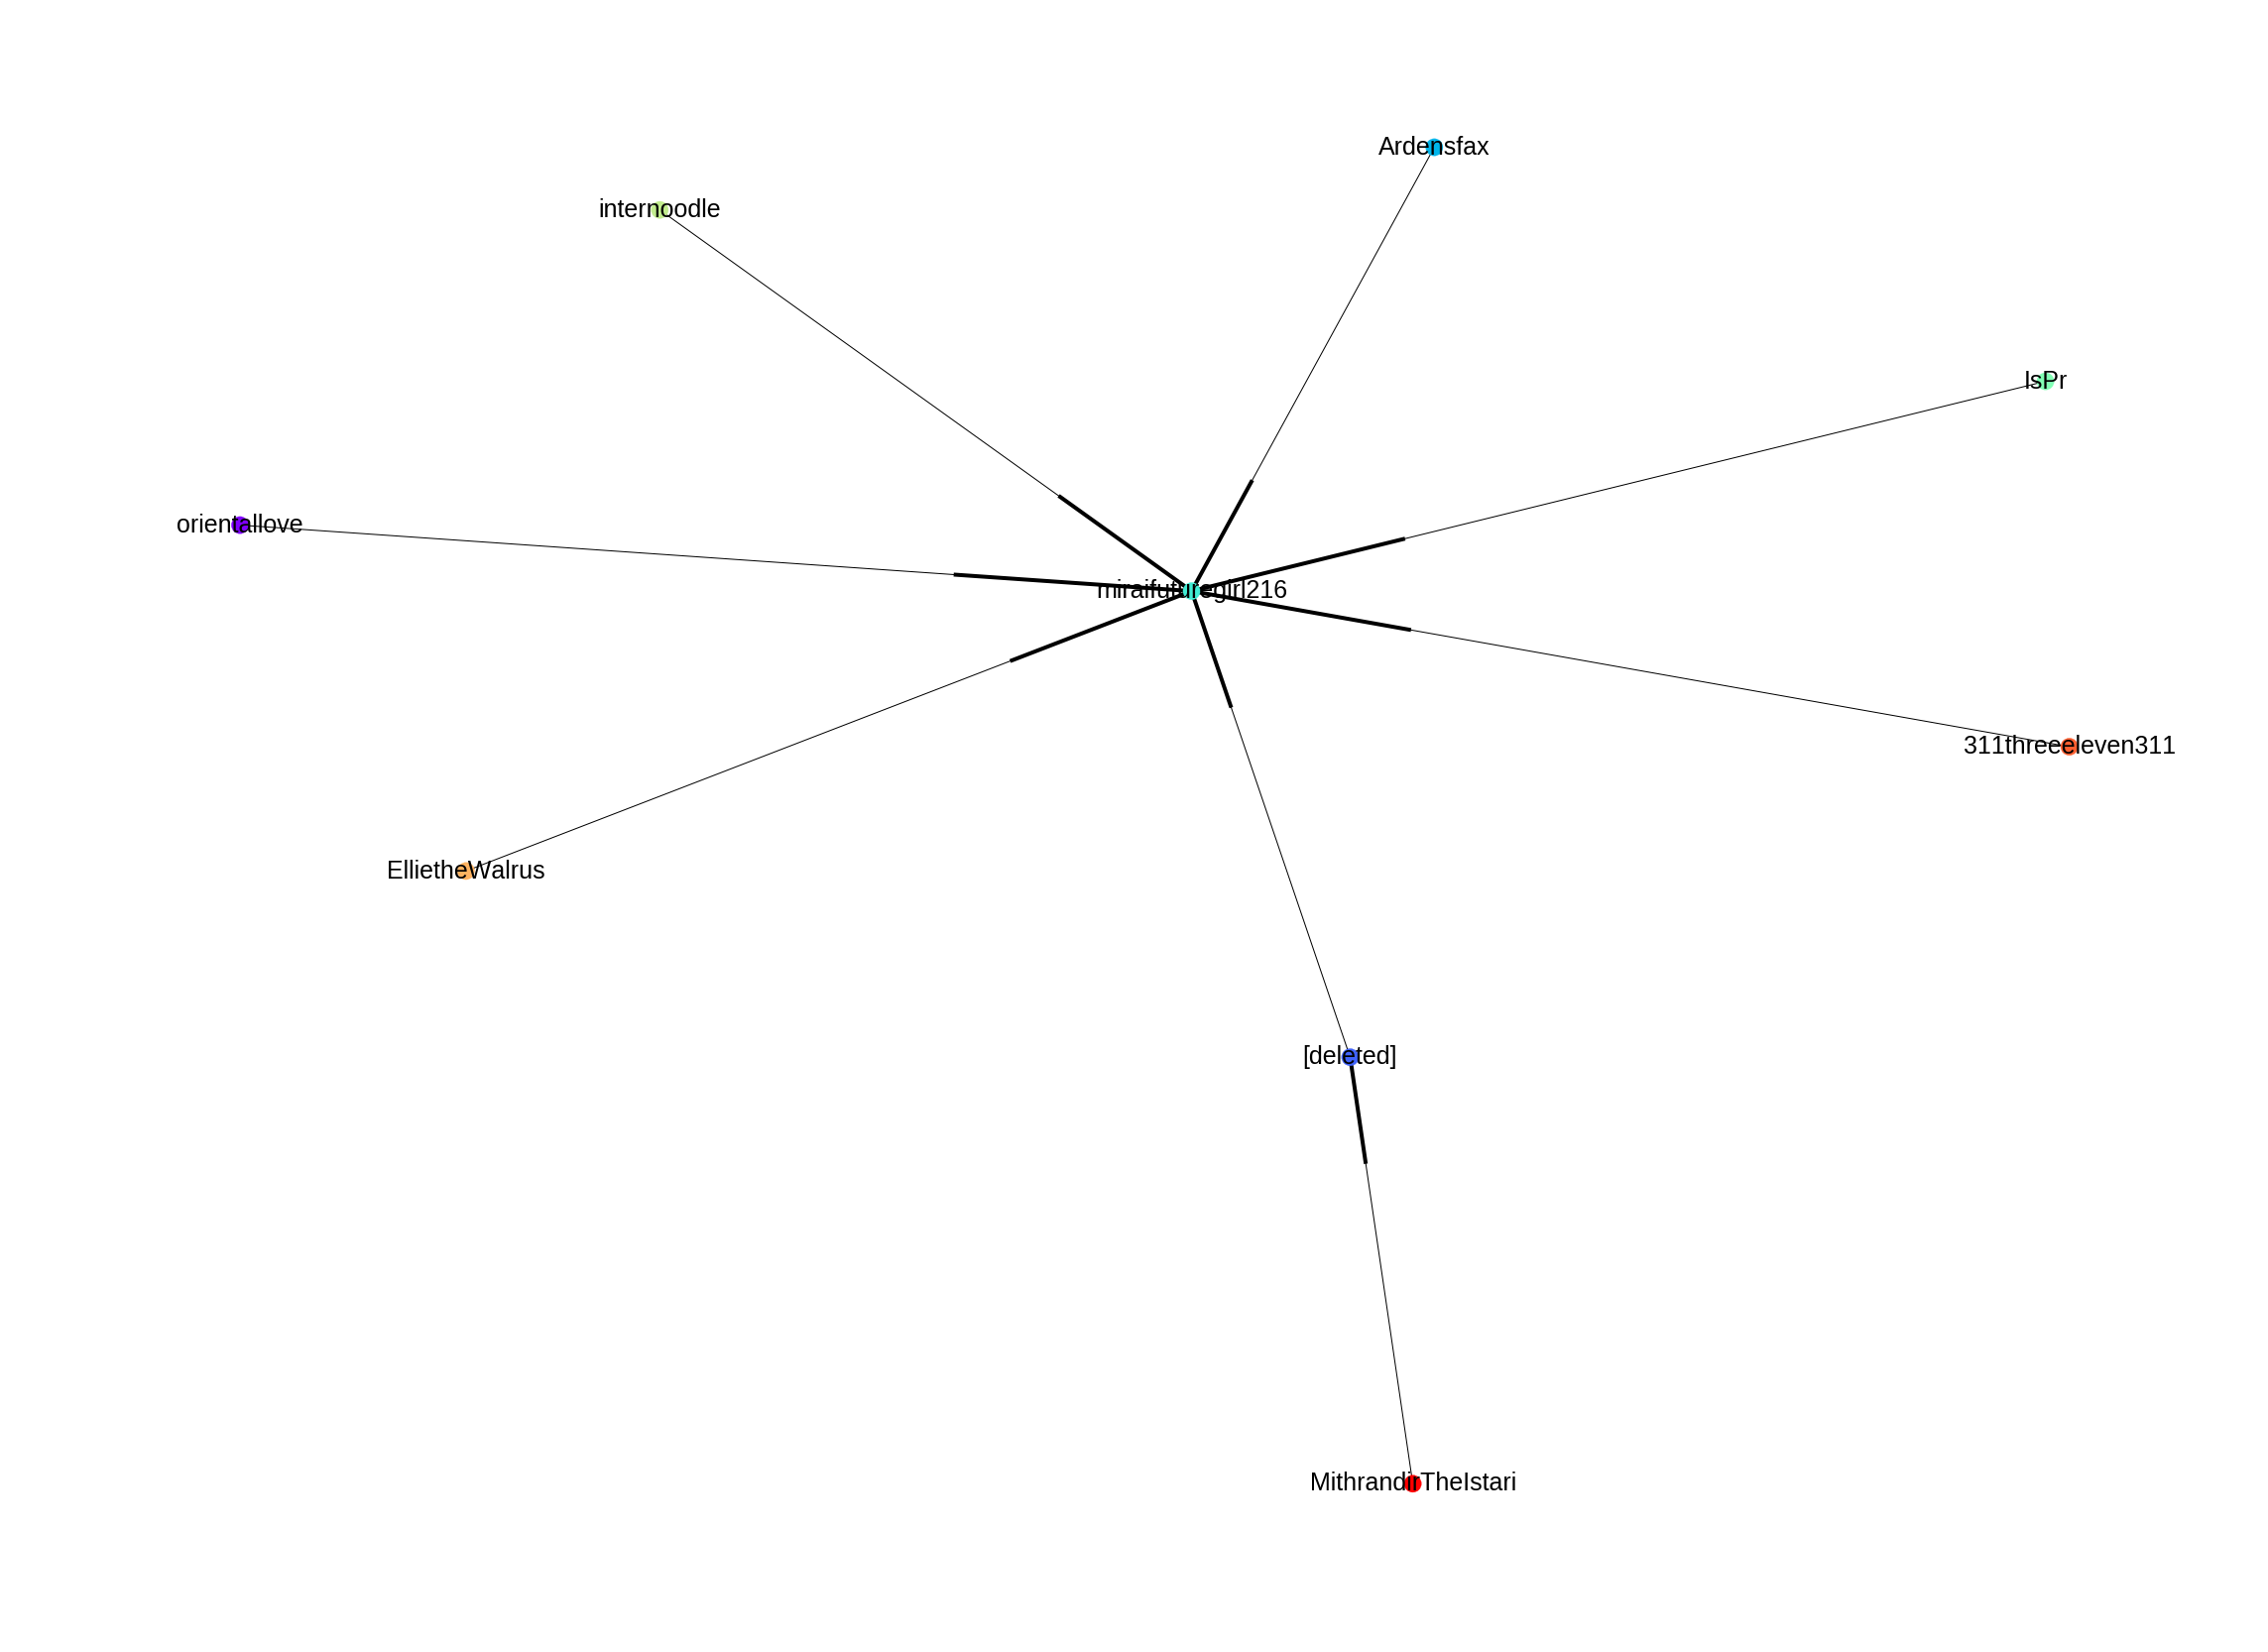

In [783]:
key = userGraphs.keys()[190]
ugraph = userGraphs[key]
# sizes = getScaledSizes(cascadeGraph)
pos = graphviz_layout(ugraph, prog='neato')

usr = ugraph.nodes()
print len(usr)
color=cm.rainbow(np.linspace(0,1,len(usr)))
colorMap = []
lls = {}
for node in ugraph:
    c = usr.index(node)
    colorMap.append(color[c])
    lls[node] = node
fig, ax = plt.subplots()
fig.set_size_inches(40, 30)
#
nx.draw(ugraph,pos=pos ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
plt.show()

In [784]:
nx.triangles(userGraphs[key].to_undirected()).values()

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [785]:
rootAffects = []
for k in allGraphs:
    g = allGraphs[k]
    for n in g.node:
        if 'depth' in g.node[n] and g.node[n]['depth'] == -1:
            rootAffects.append(g.node[n]['affects'])

In [786]:
# from collections import Counter
# Counter(rootAffects)

In [787]:
depths = []
sentiments = []
rootAuthors = []
rootSentiments = []
sentiChanges = []
sentiDeltas = [] 
participants = []
conversations = []
medianRootSentiments = []
maxRootSentiments = []
triangles = []
maxDepths = []
Zscore = []
rootEngagement = []
for k in allGraphs:
    if k in userGraphs:
        g = allGraphs[k]
        rootAuthor = None
        posChange = 0
        negChange = 0
        rootSenti = 0
        for node in g:
            if 'depth' in g.node[node]:
                if g.node[node]['depth'] == -1:
                    rootSenti = g.node[node]['affects']
                    rootAuthor = g.node[node]['author']
                    rootAuthors.append(rootAuthor)
                    rootSentiments.append(rootSenti)
        if rootSenti == 0:
            continue
            
            
        conversations.append(len(g.nodes()))
        participants.append(len(userGraphs[k].nodes()))
        threadSentiment = [rootSenti]
        if rootAuthor == None:
            continue
        else:
            for node in g:
                if 'depth' in g.node[node]:
                    if g.node[node]['author'] == rootAuthor:
                        depths.append(g.node[node]['depth'])
                        sentiments.append(g.node[node]['affects'])
                        sentiChanges.append(g.node[node]['affects'] - rootSenti)
                        rootSentiments.append(g.node[node]['affects'])
                        if (g.node[node]['affects'] - rootSenti) > 0:
                            posChange+=1
                        else:
                            negChange+=1
                        threadSentiment.append(g.node[node]['affects'])
                    
            maxDepths.append( max(nx.get_node_attributes(allGraphs[k], 'depth').values()) )
            score = (float(posChange) - float(negChange))/math.sqrt(float(posChange) + float(negChange))
            Zscore.append(score)
            medianRootSentiments.append(np.median(threadSentiment))
            maxRootSentiments.append(max(threadSentiment))
            rootEngagement.append(len(threadSentiment)-1)
            triangles.append(sum(list(nx.triangles(userGraphs[k].to_undirected()).values()))/3)
        
    
print len(rootAuthors)

37264


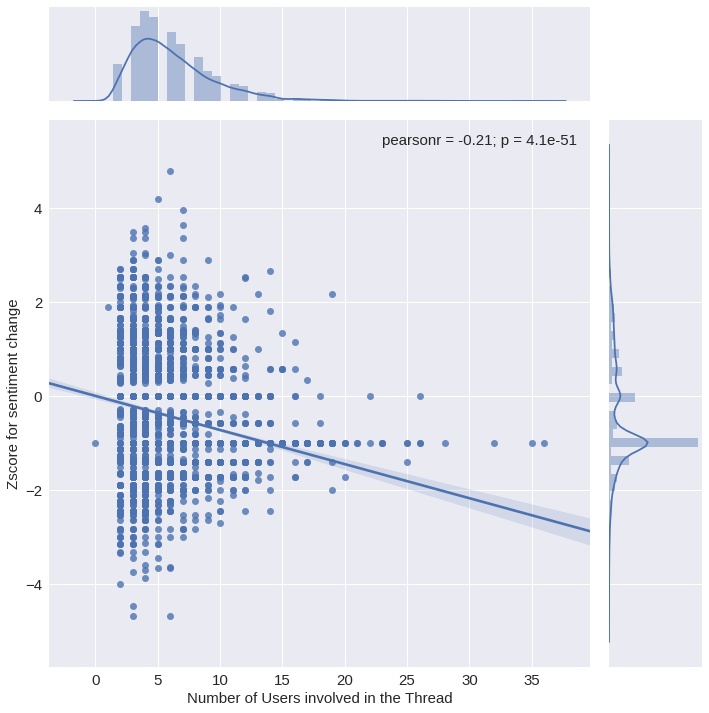

In [788]:
sns.jointplot(x = np.asarray(participants) , y = np.asarray(Zscore) , kind='reg' ,size = 10);
plt.xlabel("Number of Users involved in the Thread", fontsize = 15)
plt.ylabel("Zscore for sentiment change", fontsize = 15)

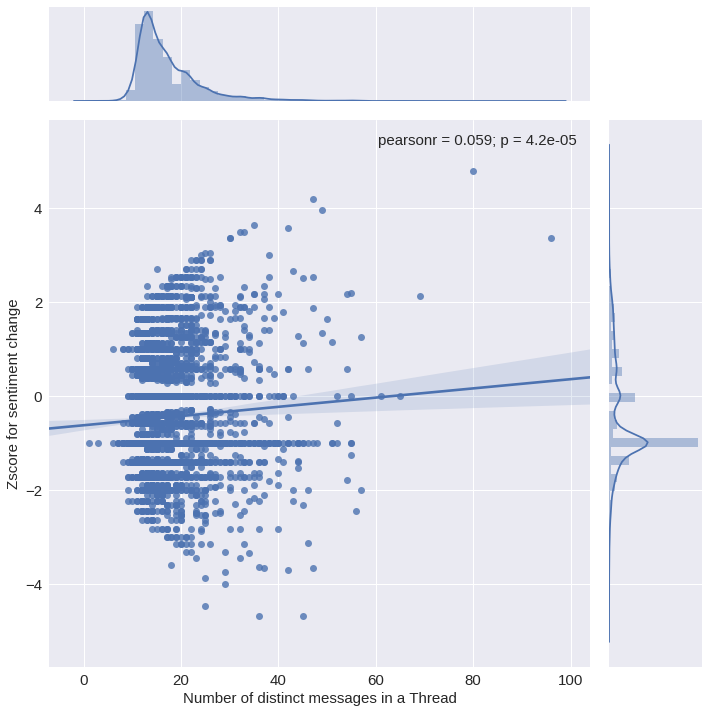

In [789]:
sns.jointplot(x = np.asarray(conversations) , y = np.asarray(Zscore) , kind='reg' ,size = 10);
plt.xlabel("Number of distinct messages in a Thread", fontsize = 15)
plt.ylabel("Zscore for sentiment change", fontsize = 15)

In [790]:
len(list(set(rootAuthors)))

18338

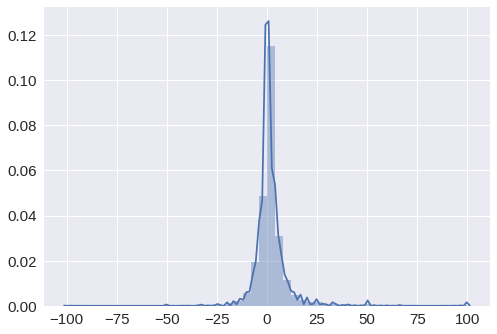

In [791]:
sns.distplot(rootSentiments)


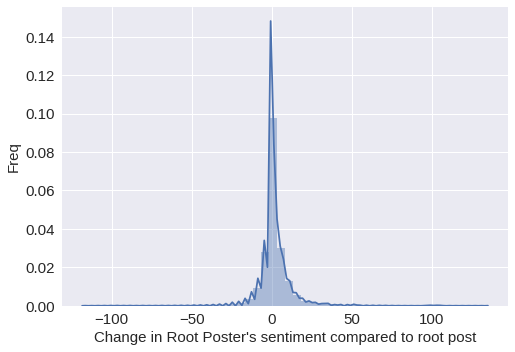

In [792]:
sns.distplot(sentiChanges,kde=True)
plt.xlabel("Change in Root Poster's sentiment compared to root post", fontsize = 15)
plt.ylabel("Freq", fontsize = 15)

In [793]:
float(len([k for k in sentiChanges if k > 0]) )/  float(len(sentiChanges))

0.44821867979030705

In [794]:
sigma = np.std(sentiChanges)
mean = np.mean(sentiChanges)


In [795]:
Zscore = [(float(k) - mean)/sigma for k in sentiChanges]

In [796]:
len(medianRootSentiments)

4815

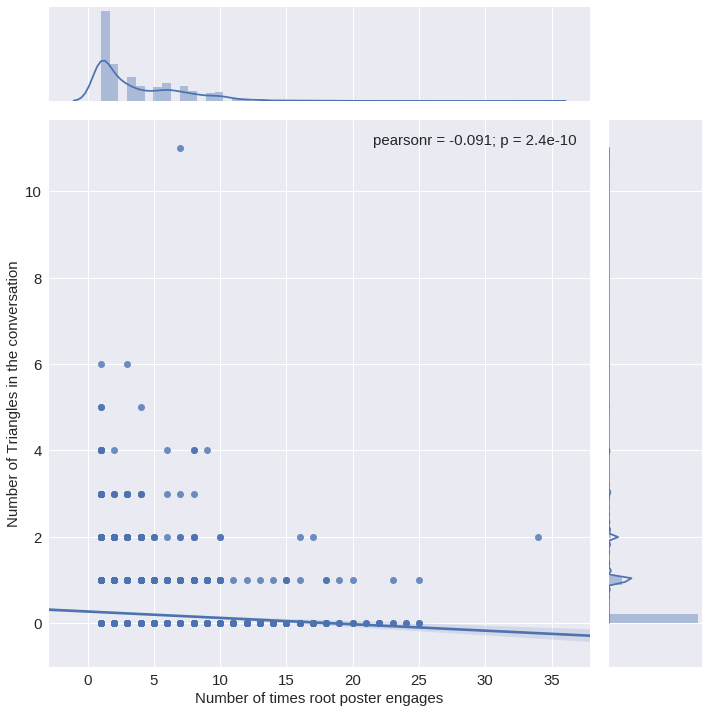

In [797]:
sns.jointplot(x = np.asarray(rootEngagement) , y = np.asarray(triangles) , kind='reg' ,size = 10);
plt.ylabel("Number of Triangles in the conversation", fontsize = 15)
plt.xlabel("Number of times root poster engages", fontsize = 15)

In [517]:
import nltk
from nltk.collocations import *
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))    
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

In [518]:
def clean(doc):

    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [524]:
textList = []
for k in allGraphs:
    postText = nx.get_node_attributes(allGraphs[k],'text')
    for t in postText:
        textList.append(postText[t])

In [525]:
textList[1]

'So they won\'t talk to you, I see. Why are you going to give this up? Why aren\'t you at least trying to be the dad they\'d like to remember? If you quit now, your kids will be remembering you as "that jerk who left us alone when we were little." Do you want that? No, you don\'t want that. If they won\'t talk to you, be a man and sort it out.'

In [ ]:
Tokenizer = TweetTokenizer()
postCorpus = []
for news in textList:
    utfnews = news
    tokens = Tokenizer.tokenize(utfnews)
    for token in tokens:
        postCorpus.append(token)

In [533]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(postCorpus, window_size = 4)
finder.apply_freq_filter(100)
print sorted(finder.nbest(trigram_measures.pmi, 30))

[(u'*', u'TL', u';D'), (u'/', u'r', u'SuicideWatch'), (u'/', u'r', u'suicidewatch'), (u';D', u'R', u':'), (u'Feel', u'free', u'PM'), (u'Long', u'story', u'short'), (u'TL', u';D', u'R'), (u']', u'^', u'^'), (u'^', u'^', u'^'), (u'a', u'chemical', u'imbalance'), (u'deleted', u'^', u'^'), (u'didn', u'\u2019', u't'), (u'doesn', u'\u2019', u't'), (u'don', u'\u2019', u't'), (u'grand', u'scheme', u'of'), (u'hit', u'rock', u'bottom'), (u'low', u'self', u'esteem'), (u'on', u'daily', u'basis'), (u'play', u'video', u'games'), (u'playing', u'video', u'games'), (u'r', u'/', u'SuicideWatch'), (u'r', u'/', u'suicidewatch'), (u'take', u'deep', u'breath'), (u'the', u'U', u'S'), (u'the', u'grand', u'scheme'), (u'tl', u';d', u'r'), (u'ups', u'and', u'downs'), (u'vast', u'majority', u'of'), (u'your', u'comfort', u'zone'), (u'~', u'~', u'~')]


In [534]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(postCorpus, window_size = 3)
finder.apply_freq_filter(200)
print sorted(finder.nbest(bigram_measures.pmi, 30))

[(u'100', u'%'), (u';D', u'R'), (u';d', u'r'), (u'Of', u'course'), (u'TL', u'R'), (u'^', u'^'), (u'along', u'lines'), (u'bipolar', u'disorder'), (u'blah', u'blah'), (u'chemical', u'imbalance'), (u'daily', u'basis'), (u'don', u't'), (u'don', u'\u2019'), (u'fall', u'asleep'), (u'falling', u'apart'), (u'human', u'beings'), (u'minimum', u'wage'), (u'panic', u'attack'), (u'panic', u'attacks'), (u'permanent', u'solution'), (u'psych', u'ward'), (u'r', u'suicidewatch'), (u'rock', u'bottom'), (u'self', u'esteem'), (u'socially', u'awkward'), (u'student', u'loans'), (u'ups', u'downs'), (u'video', u'games'), (u'~', u'~'), (u'\u2019', u'm')]


In [535]:
print sorted(finder.nbest(trigram_measures.pmi, 30))

[(u'100', u'%'), (u';D', u'R'), (u';d', u'r'), (u'Of', u'course'), (u'TL', u'R'), (u'^', u'^'), (u'along', u'lines'), (u'bipolar', u'disorder'), (u'blah', u'blah'), (u'chemical', u'imbalance'), (u'daily', u'basis'), (u'don', u't'), (u'don', u'\u2019'), (u'fall', u'asleep'), (u'falling', u'apart'), (u'human', u'beings'), (u'minimum', u'wage'), (u'panic', u'attack'), (u'panic', u'attacks'), (u'permanent', u'solution'), (u'psych', u'ward'), (u'r', u'suicidewatch'), (u'rock', u'bottom'), (u'self', u'esteem'), (u'socially', u'awkward'), (u'student', u'loans'), (u'ups', u'downs'), (u'video', u'games'), (u'~', u'~'), (u'\u2019', u'm')]


In [536]:
print sorted(finder.nbest(bigram_measures.pmi, 30))

[(u'100', u'%'), (u';D', u'R'), (u';d', u'r'), (u'Of', u'course'), (u'TL', u'R'), (u'^', u'^'), (u'along', u'lines'), (u'bipolar', u'disorder'), (u'blah', u'blah'), (u'chemical', u'imbalance'), (u'daily', u'basis'), (u'don', u't'), (u'don', u'\u2019'), (u'fall', u'asleep'), (u'falling', u'apart'), (u'human', u'beings'), (u'minimum', u'wage'), (u'panic', u'attack'), (u'panic', u'attacks'), (u'permanent', u'solution'), (u'psych', u'ward'), (u'r', u'suicidewatch'), (u'rock', u'bottom'), (u'self', u'esteem'), (u'socially', u'awkward'), (u'student', u'loans'), (u'ups', u'downs'), (u'video', u'games'), (u'~', u'~'), (u'\u2019', u'm')]
